# Practice 13 — Regularization

Original Authors: Seungjae Ryan Lee, Ki Hyun Kim
Source: https://github.com/deeplearningzerotoall/PyTorch

모델 용량이 클수록 **과적합 위험**이 높아집니다. 규제(Regularization)로 일반화 성능을 향상시킵니다.

| 기법 | 핵심 |
|------|------|
| L2 (Weight Decay) | 가중치 크기에 벌칙 → 작은 가중치 유지 |
| L1 (Lasso) | 가중치를 0으로 → 희소 모델 |
| Dropout | 랜덤 노드 제거 → 앙상블 효과 |

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

torch.manual_seed(42)
np.random.seed(42)

# 과적합을 유발하기 위해 학습 데이터를 10%만 사용 (179개)
digits = load_digits()
X, y = digits.data, digits.target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.9, random_state=42, stratify=y)

mu = X_train.mean(0)
sigma = X_train.std(0) + 1e-8
X_train_s = (X_train - mu) / sigma
X_test_s = (X_test - mu) / sigma

train_loader = DataLoader(
    TensorDataset(torch.FloatTensor(X_train_s), torch.LongTensor(y_train)),
    batch_size=32, shuffle=True)
test_loader = DataLoader(
    TensorDataset(torch.FloatTensor(X_test_s), torch.LongTensor(y_test)),
    batch_size=256)

print(f'Train: {len(y_train)}, Test: {len(y_test)}')

Train: 179, Test: 1618


In [2]:
# 모델을 학습하고 epoch별 (train_loss, test_loss, test_acc) 리스트를 반환합니다.
def train(model, train_loader, test_loader, optimizer, epochs=150):
    criterion = nn.CrossEntropyLoss()
    train_losses = []
    test_losses = []
    test_accs = []

    for epoch in range(epochs):
        # 훈련
        model.train()
        loss_sum = 0
        count = 0
        for X_batch, Y_batch in train_loader:
            output = model(X_batch)
            loss = criterion(output, Y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_sum += loss.item() * len(Y_batch)
            count += len(Y_batch)
        train_losses.append(loss_sum / count)

        # 테스트
        model.eval()
        loss_sum = 0
        correct = 0
        count = 0
        with torch.no_grad():
            for X_batch, Y_batch in test_loader:
                output = model(X_batch)
                loss_sum += criterion(output, Y_batch).item() * len(Y_batch)
                correct += (output.argmax(1) == Y_batch).sum().item()
                count += len(Y_batch)
        test_losses.append(loss_sum / count)
        test_accs.append(correct / count)

    return train_losses, test_losses, test_accs

---
# 1. L2 규제 (Weight Decay)

가중치 크기의 **제곱합**에 벌칙을 부여합니다.

$$J_{\text{reg}} = J(\theta) + \lambda \|\theta\|_2^2$$

PyTorch에서는 optimizer의 `weight_decay` 파라미터로 간단히 사용합니다.

No Reg -> Test Acc: 0.904
L2     -> Test Acc: 0.916


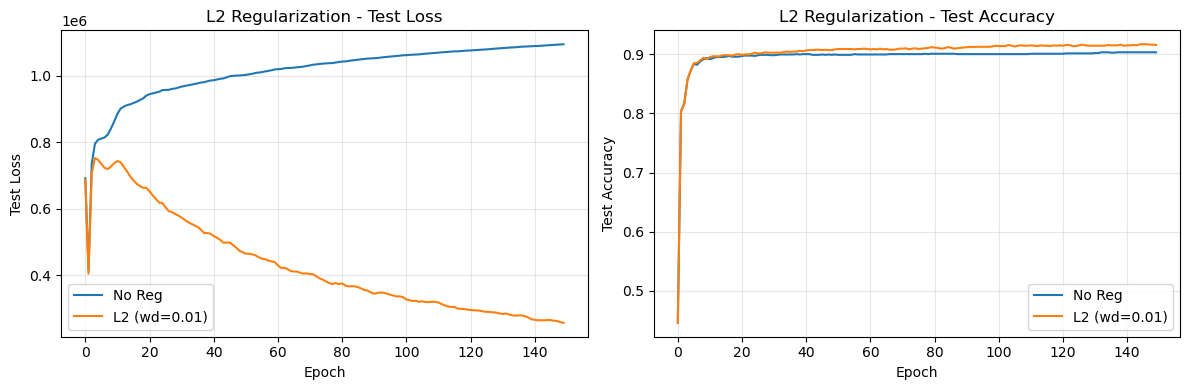

L2는 가중치 크기를 제한하여 과적합을 줄입니다.


In [3]:
# === 규제 없음 (Baseline) ===
torch.manual_seed(42)
model_base = nn.Sequential(
    nn.Linear(64, 256), nn.ReLU(),
    nn.Linear(256, 256), nn.ReLU(),
    nn.Linear(256, 256), nn.ReLU(),
    nn.Linear(256, 10)
)
for layer in model_base:  # He 초기화 (Practice 12에서 배운 기법)
    if isinstance(layer, nn.Linear):
        nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')
optimizer_base = torch.optim.SGD(model_base.parameters(), lr=0.01, momentum=0.9)
tl_base, vl_base, va_base = train(model_base, train_loader, test_loader, optimizer_base)

# === L2 규제 (weight_decay=0.01) ===
torch.manual_seed(42)
model_l2 = nn.Sequential(
    nn.Linear(64, 256), nn.ReLU(),
    nn.Linear(256, 256), nn.ReLU(),
    nn.Linear(256, 256), nn.ReLU(),
    nn.Linear(256, 10)
)
for layer in model_l2:
    if isinstance(layer, nn.Linear):
        nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')
optimizer_l2 = torch.optim.SGD(model_l2.parameters(), lr=0.01, momentum=0.9, weight_decay=0.01)
tl_l2, vl_l2, va_l2 = train(model_l2, train_loader, test_loader, optimizer_l2)

print(f'No Reg -> Test Acc: {va_base[-1]:.3f}')
print(f'L2     -> Test Acc: {va_l2[-1]:.3f}')

# 비교 그래프
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(vl_base, label='No Reg')
axes[0].plot(vl_l2, label='L2 (wd=0.01)')
axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('Test Loss')
axes[0].set_title('L2 Regularization - Test Loss')
axes[0].legend(); axes[0].grid(alpha=0.3)
axes[1].plot(va_base, label='No Reg')
axes[1].plot(va_l2, label='L2 (wd=0.01)')
axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('Test Accuracy')
axes[1].set_title('L2 Regularization - Test Accuracy')
axes[1].legend(); axes[1].grid(alpha=0.3)
plt.tight_layout(); plt.show()
print('L2는 가중치 크기를 제한하여 과적합을 줄입니다.')

---
# 2. L1 규제와 가중치 분포

L1 규제는 가중치를 **정확히 0으로** 만드는 경향이 있습니다 (희소성).

PyTorch에는 L1이 내장되어 있지 않으므로 수동으로 구현합니다.

$$J_{\text{reg}} = J(\theta) + \lambda \|\theta\|_1$$

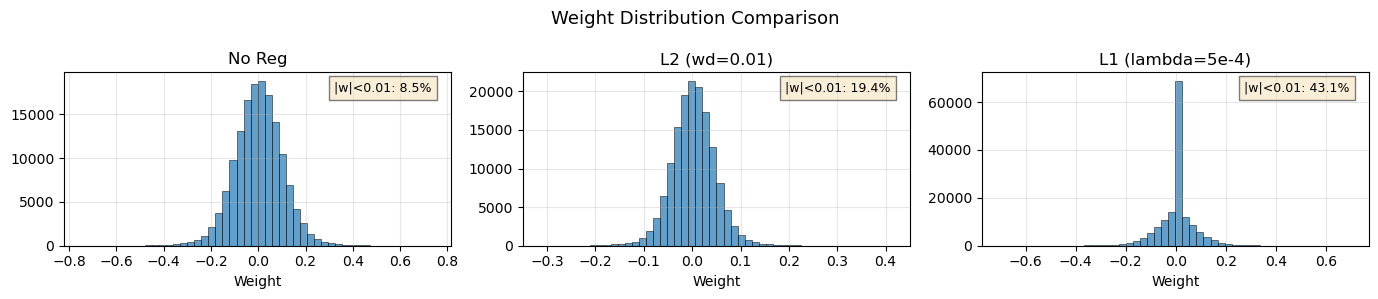

L1은 많은 가중치를 0으로 만들어 희소(sparse) 모델을 생성합니다.
L2는 전체 가중치를 균일하게 작게 유지합니다.


In [4]:
# === L1 규제 (직접 구현) ===
torch.manual_seed(42)
model_l1 = nn.Sequential(
    nn.Linear(64, 256), nn.ReLU(),
    nn.Linear(256, 256), nn.ReLU(),
    nn.Linear(256, 256), nn.ReLU(),
    nn.Linear(256, 10)
)
for layer in model_l1:
    if isinstance(layer, nn.Linear):
        nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')
optimizer_l1 = torch.optim.SGD(model_l1.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()
l1_lambda = 5e-4

# L1은 loss에 가중치 절대값 합을 직접 더해줍니다
for epoch in range(150):
    model_l1.train()
    for X_batch, Y_batch in train_loader:
        output = model_l1(X_batch)
        ce_loss = criterion(output, Y_batch)
        l1_penalty = sum(p.abs().sum() for p in model_l1.parameters())
        loss = ce_loss + l1_lambda * l1_penalty
        optimizer_l1.zero_grad()
        loss.backward()
        optimizer_l1.step()

# 가중치 분포 비교 (No Reg vs L2 vs L1)
fig, axes = plt.subplots(1, 3, figsize=(14, 3))

w_base = torch.cat([p.data.flatten() for p in model_base.parameters()]).numpy()
axes[0].hist(w_base, bins=50, alpha=0.7, edgecolor='black', linewidth=0.5)
axes[0].set_title('No Reg'); axes[0].set_xlabel('Weight')
near_zero = (np.abs(w_base) < 0.01).mean()
axes[0].text(0.95, 0.95, f'|w|<0.01: {near_zero:.1%}', transform=axes[0].transAxes,
             ha='right', va='top', fontsize=9, bbox=dict(facecolor='wheat', alpha=0.5))

w_l2 = torch.cat([p.data.flatten() for p in model_l2.parameters()]).numpy()
axes[1].hist(w_l2, bins=50, alpha=0.7, edgecolor='black', linewidth=0.5)
axes[1].set_title('L2 (wd=0.01)'); axes[1].set_xlabel('Weight')
near_zero = (np.abs(w_l2) < 0.01).mean()
axes[1].text(0.95, 0.95, f'|w|<0.01: {near_zero:.1%}', transform=axes[1].transAxes,
             ha='right', va='top', fontsize=9, bbox=dict(facecolor='wheat', alpha=0.5))

w_l1 = torch.cat([p.data.flatten() for p in model_l1.parameters()]).numpy()
axes[2].hist(w_l1, bins=50, alpha=0.7, edgecolor='black', linewidth=0.5)
axes[2].set_title('L1 (lambda=5e-4)'); axes[2].set_xlabel('Weight')
near_zero = (np.abs(w_l1) < 0.01).mean()
axes[2].text(0.95, 0.95, f'|w|<0.01: {near_zero:.1%}', transform=axes[2].transAxes,
             ha='right', va='top', fontsize=9, bbox=dict(facecolor='wheat', alpha=0.5))

for ax in axes:
    ax.grid(alpha=0.3)
plt.suptitle('Weight Distribution Comparison', fontsize=13)
plt.tight_layout(); plt.show()
print('L1은 많은 가중치를 0으로 만들어 희소(sparse) 모델을 생성합니다.')
print('L2는 전체 가중치를 균일하게 작게 유지합니다.')

---
# 3. 드롭아웃 (Dropout)

훈련 시 매 iteration마다 **랜덤으로 노드를 비활성화** → 암묵적 앙상블 효과

- `nn.Dropout(p)`: p = 비활성화 확률
- `model.train()` → 드롭아웃 활성
- `model.eval()` → 드롭아웃 비활성 (전체 노드 사용)

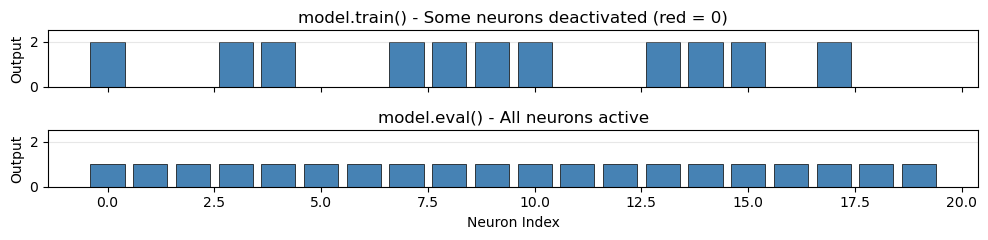

train(): 9/20 neurons deactivated, active neurons scaled by 1/(1-p) = 2.0
eval() : 0/20 neurons deactivated, all outputs = original value


In [5]:
# Dropout의 train() vs eval() 동작 비교
torch.manual_seed(0)
dropout = nn.Dropout(p=0.5)

x = torch.ones(1, 20)  # 20개 뉴런, 모두 활성화 값 1.0

# train 모드: 랜덤으로 뉴런 비활성화 (0으로), 나머지는 1/(1-p) 배로 스케일링
dropout.train()
out_train = dropout(x)

# eval 모드: 모든 뉴런 활성화 (원래 값 그대로)
dropout.eval()
out_eval = dropout(x)

fig, axes = plt.subplots(2, 1, figsize=(10, 2.5), sharex=True)
colors_train = ['salmon' if v == 0 else 'steelblue' for v in out_train[0]]
axes[0].bar(range(20), out_train[0].numpy(), color=colors_train, edgecolor='black', linewidth=0.5)
axes[0].set_ylabel('Output')
axes[0].set_title('model.train() - Some neurons deactivated (red = 0)')
axes[0].set_ylim(0, 2.5)
axes[0].grid(alpha=0.3, axis='y')

axes[1].bar(range(20), out_eval[0].numpy(), color='steelblue', edgecolor='black', linewidth=0.5)
axes[1].set_ylabel('Output')
axes[1].set_xlabel('Neuron Index')
axes[1].set_title('model.eval() - All neurons active')
axes[1].set_ylim(0, 2.5)
axes[1].grid(alpha=0.3, axis='y')
plt.tight_layout(); plt.show()

n_off = (out_train[0] == 0).sum().item()
print(f'train(): {n_off}/20 neurons deactivated, active neurons scaled by 1/(1-p) = {1/(1-0.5):.1f}')
print(f'eval() : 0/20 neurons deactivated, all outputs = original value')

No Dropout  -> Test Acc: 0.904
Dropout 0.3 -> Test Acc: 0.924


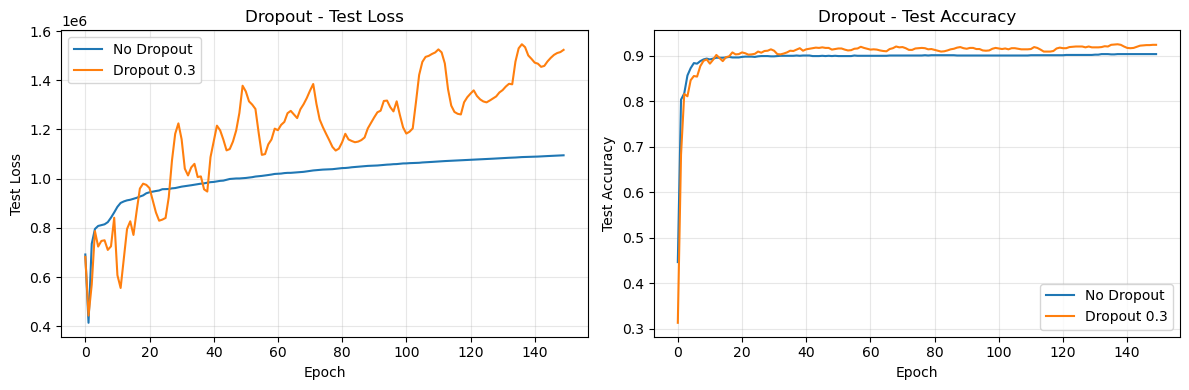

Dropout은 과적합을 줄여 일반화 성능을 향상시킵니다.


In [6]:
# === Dropout 없음 ===
torch.manual_seed(42)
model_no_drop = nn.Sequential(
    nn.Linear(64, 256), nn.ReLU(),
    nn.Linear(256, 256), nn.ReLU(),
    nn.Linear(256, 256), nn.ReLU(),
    nn.Linear(256, 10)
)
for layer in model_no_drop:
    if isinstance(layer, nn.Linear):
        nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')
optimizer_no_drop = torch.optim.SGD(model_no_drop.parameters(), lr=0.01, momentum=0.9)
tl_no, vl_no, va_no = train(model_no_drop, train_loader, test_loader, optimizer_no_drop)

# === Dropout 0.3 ===
torch.manual_seed(42)
model_drop = nn.Sequential(
    nn.Linear(64, 256), nn.ReLU(), nn.Dropout(0.3),
    nn.Linear(256, 256), nn.ReLU(), nn.Dropout(0.3),
    nn.Linear(256, 256), nn.ReLU(), nn.Dropout(0.3),
    nn.Linear(256, 10)
)
for layer in model_drop:
    if isinstance(layer, nn.Linear):
        nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')
optimizer_drop = torch.optim.SGD(model_drop.parameters(), lr=0.01, momentum=0.9)
tl_drop, vl_drop, va_drop = train(model_drop, train_loader, test_loader, optimizer_drop)

print(f'No Dropout  -> Test Acc: {va_no[-1]:.3f}')
print(f'Dropout 0.3 -> Test Acc: {va_drop[-1]:.3f}')

# 비교 그래프
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(vl_no, label='No Dropout')
axes[0].plot(vl_drop, label='Dropout 0.3')
axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('Test Loss')
axes[0].set_title('Dropout - Test Loss')
axes[0].legend(); axes[0].grid(alpha=0.3)
axes[1].plot(va_no, label='No Dropout')
axes[1].plot(va_drop, label='Dropout 0.3')
axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('Test Accuracy')
axes[1].set_title('Dropout - Test Accuracy')
axes[1].legend(); axes[1].grid(alpha=0.3)
plt.tight_layout(); plt.show()
print('Dropout은 과적합을 줄여 일반화 성능을 향상시킵니다.')

**Q. Dropout 모델의 Test Loss가 더 높은 이유는?**

Dropout 없는 모델은 학습 데이터에 과적합하여 logit이 극단적으로 커집니다 (`softmax([10, 0, ...])` ≈ `[0.99, ...]`).
맞추면 loss가 거의 0에 가깝습니다.

반면 Dropout 모델은 과적합이 억제되어 logit이 상대적으로 작습니다 (`softmax([3, 1, ...])` ≈ `[0.7, ...]`).
**맞추더라도 확신도가 낮아** loss가 더 큽니다.

→ Test Loss가 높다고 성능이 나쁜 것이 아닙니다. 실제 **Accuracy는 Dropout 모델이 더 높습니다.**

---
# 4. 하이퍼파라미터 탐색 (Hyperparameter Search)

규제 강도, 학습률 등은 **하이퍼파라미터**로, 별도의 탐색이 필요합니다.

| 방법 | 장점 | 단점 |
|------|------|------|
| Grid Search | 체계적, 재현 가능 | 조합 폭발 ($q^m$) |
| Random Search | 중요 파라미터에 유리 | 비체계적 |

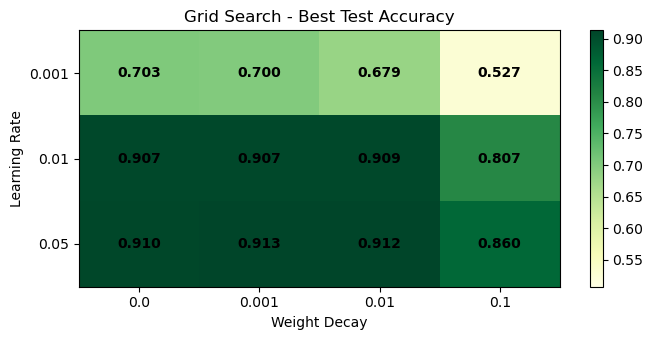

Best: lr=0.05, wd=0.001 -> Acc: 0.913


In [7]:
# Learning Rate x Weight Decay Grid Search
lr_values = [0.001, 0.01, 0.05]
wd_values = [0.0, 0.001, 0.01, 0.1]
grid = np.zeros((len(lr_values), len(wd_values)))

for i, lr in enumerate(lr_values):
    for j, wd in enumerate(wd_values):
        torch.manual_seed(42)
        model = nn.Sequential(
            nn.Linear(64, 128), nn.ReLU(),
            nn.Linear(128, 64), nn.ReLU(),
            nn.Linear(64, 10))
        _, _, va = train(model, train_loader, test_loader,
                         torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=wd),
                         epochs=80)
        grid[i, j] = max(va)

# 히트맵
fig, ax = plt.subplots(figsize=(7, 3.5))
im = ax.imshow(grid, cmap='YlGn', aspect='auto', vmin=grid.min() - 0.02, vmax=grid.max())
ax.set_xticks(range(len(wd_values)))
ax.set_xticklabels(wd_values)
ax.set_yticks(range(len(lr_values)))
ax.set_yticklabels(lr_values)
ax.set_xlabel('Weight Decay')
ax.set_ylabel('Learning Rate')
ax.set_title('Grid Search - Best Test Accuracy')
for i in range(len(lr_values)):
    for j in range(len(wd_values)):
        ax.text(j, i, f'{grid[i,j]:.3f}', ha='center', va='center', fontweight='bold')
plt.colorbar(im)
plt.tight_layout(); plt.show()

best = np.unravel_index(grid.argmax(), grid.shape)
print(f'Best: lr={lr_values[best[0]]}, wd={wd_values[best[1]]} -> Acc: {grid[best]:.3f}')

---
### 연습 문제

1. L2 규제 강도(`weight_decay`)를 0.001, 0.01, 0.1로 변화시키며 학습 곡선을 비교하세요.
2. Dropout을 0.1, 0.3, 0.5로 바꿀 때 테스트 정확도가 어떻게 달라지는지 비교하세요.

In [8]:
# 연습 문제 풀이 공간
